In [34]:
# ==========================================
# DRONE PROLIFERATION & IMPACT ANALYSIS
# Auteur: Warre Gehre
# Datum: December 2025
# ==========================================

# ---------------------------------------------------------
# STAP 0: GLOBAL SETUP & IMPORTS
# ---------------------------------------------------------
# Hier laden we alle bibliotheken in één keer in om het overzichtelijk te houden.

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import ipywidgets as widgets
from IPython.display import display, clear_output

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, year, month, to_date, sum as spark_sum, avg, count, round as spark_round

In [35]:
# Visualisatie instellingen
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Initialiseer de Spark Sessie (Eén keer voor het hele project)
spark = SparkSession.builder \
    .appName("Drone Proliferation & Impact Project") \
    .getOrCreate()

print("Spark Sessie gestart.")

Spark Sessie gestart.


# Intro datasets

Inladen en basis cleaning toepassen

## Cleanen van datasets

In [36]:
# --- 1. CNAS Data Schoonmaken ---
print("Verwerken CNAS dataset...")
raw_cnas = "/kaggle/input/cnas-dataset/Proliferation_Master Sheet_Sept 2024.xlsx"

# Inladen
df_cnas_pd = pd.read_excel(raw_cnas, sheet_name=0)

# Cleaning: Verwijder spaties uit kolomnamen (bv. 'Region ' -> 'Region')
df_cnas_pd.columns = df_cnas_pd.columns.str.strip()

# Cleaning: Verwijder spaties uit ALLE tekstcellen (bv. ' Afghanistan' -> 'Afghanistan')
df_cnas_obj = df_cnas_pd.select_dtypes(['object'])
df_cnas_pd[df_cnas_obj.columns] = df_cnas_obj.apply(lambda x: x.str.strip())

# Opslaan als schone CSV
df_cnas_pd.to_csv("cnas_clean.csv", index=False)
print("CNAS data opgeschoond en opgeslagen als 'cnas_clean.csv'.")

Verwerken CNAS dataset...
CNAS data opgeschoond en opgeslagen als 'cnas_clean.csv'.


In [37]:
# Drone Wars Data Schoonmaken
print("Verwerken Drone Wars dataset...")
raw_wars = "/kaggle/input/drone-strikes/DroneWarsData (3).xlsx"

# Inladen
df_wars_pd = pd.read_excel(raw_wars, sheet_name="All")

# Cleaning: Kolomnamen en Cellen strippen
df_wars_pd.columns = df_wars_pd.columns.str.strip()
df_wars_obj = df_wars_pd.select_dtypes(['object'])
df_wars_pd[df_wars_obj.columns] = df_wars_obj.apply(lambda x: x.str.strip())

# Opslaan
df_wars_pd.to_csv("dronewars_clean.csv", index=False)
print("Drone Wars 'All' sheet opgeschoond en opgeslagen als 'dronewars_clean.csv'.")

Verwerken Drone Wars dataset...
Drone Wars 'All' sheet opgeschoond en opgeslagen als 'dronewars_clean.csv'.


# 1. De wereldwijde Drone Markt (CNAS)

Een database van het Center for the Study of the Drone (CNAS) met informatie over welke landen welke UAV‑typen bezitten (armed/unarmed, MALE/HALE, loitering munitions, etc.) en wie deze levert aan wie.

Bevat per land kenmerken van de dronevloot (model, type, herkomst, bewapening), waardoor je de wereldwijde proliferatie en militarisering van drones in kaart kan brengen.

**Doel: In kaart brengen wie drones levert aan welke regio's**

In [38]:


df = spark.read.csv("/kaggle/working/cnas_drone_proliferation.csv", header=True, inferSchema=True)

# Stap 3: Bekijk de structuur (schema)
# Dit vertelt je welke kolommen je hebt en welk type (String, Integer) ze zijn
df.printSchema()

# Stap 4: Bekijk de eerste 5 rijen netjes


root
 |-- Entry Number : string (nullable = true)
 |-- Region : string (nullable = true)
 |-- Seeker: string (nullable = true)
 |-- Supplier: string (nullable = true)
 |-- Paltform Model: string (nullable = true)
 |-- Platform  Type: string (nullable = true)
 |-- Year of Interest : double (nullable = true)
 |-- Year of Order: double (nullable = true)
 |-- Year of First Delivery: double (nullable = true)
 |-- Year of  Identification, Completion, or Cancellation: double (nullable = true)
 |-- Status: string (nullable = true)
 |-- Source 1: string (nullable = true)
 |-- Source 2: string (nullable = true)
 |-- Source 3: string (nullable = true)
 |-- Comments: string (nullable = true)



## Analyse: 
### Belangrijke features:

- Supplier vs. Seeker: Dit is de kern van denetwerk-analyse.

Doel: We kunnen hiermee de "flow" van wapens in kaart brengen (wie bevoorraadt wie?) met behulp van folium.

- Platform Type:

Waarde: Hiermee maken we onderscheid tussen simpele verkenners (UAV) en dodelijke wapens (Armed UAV / Loitering Munition).

Trend: De verschuiving van UAV naar Loitering Munition is wat ik verwacht

- Year of Order / Year of First Delivery:

Waarde: Dit is de tijdsas. Zonder dit kunnen we geen evolutie tonen.

### Eerst wat technische fixes:

- Er staat Paltform Model in plaats van Platform Model
- De jaren (bv. Year of Order) zijn double (bv. 1992.0). Voor een visualisatie willen we liever een geheel getal (Integer: 1992) of een datum
- nullable = true betekent dat data kan ontbreken. Bij visualisaties moeten we straks beslissen: laten we lege jaren weg of vullen we ze op?

## Extra cleanen

In [39]:
from pyspark.sql.functions import col

# 1. Kolom hernoemen (Fix de typo)
# We maken een nieuwe DataFrame 'df_clean' zodat we de originele 'df' niet kwijt zijn
df_clean = df.withColumnRenamed("Paltform Model", "Platform Model")

# 2. Jaren omzetten van Double (1995.0) naar Integer (1995)
# We doen dit alleen voor de kolommen die we echt gaan gebruiken
df_clean = df_clean.withColumn("Year of Order", col("Year of Order").cast("integer")) \
                   .withColumn("Year of First Delivery", col("Year of First Delivery").cast("integer"))

# 3. Eerste Analyse: Wie zijn de grootste leveranciers?
print("Top 5 Drone Leveranciers (Suppliers):")
df_clean.groupBy("Supplier") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(5)

# 4. Tweede Analyse: Wat voor type drones worden verhandeld?
print("Verdeling per Type:")
df_clean.groupBy("Platform  Type") \
    .count() \
    .show(truncate=False)


Top 5 Drone Leveranciers (Suppliers):
+-------------+-----+
|     Supplier|count|
+-------------+-----+
|United States|  198|
|       Israel|  190|
|       Turkey|   69|
|         Iran|   56|
|        China|   55|
+-------------+-----+
only showing top 5 rows

Verdeling per Type:
+------------------+-----+
|Platform  Type    |count|
+------------------+-----+
|Armed UAV         |146  |
|NULL              |12   |
|UAV               |513  |
|Armed UAV         |1    |
|Loitering Munition|60   |
+------------------+-----+



## Conclusie Leveranciers
### Wie zijn de grootste leveranciers ? 

1. United States
2. Israel
3. Turkije
4. Iran
5. China

### Welke types drones worden vooral verhandeld ? 

- Loitering Munition --> Dit zijn kamikaze drones. We zullen een specifiek type drone, 'Shahed' vaker zien terugkomen

### Trends van type drones

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

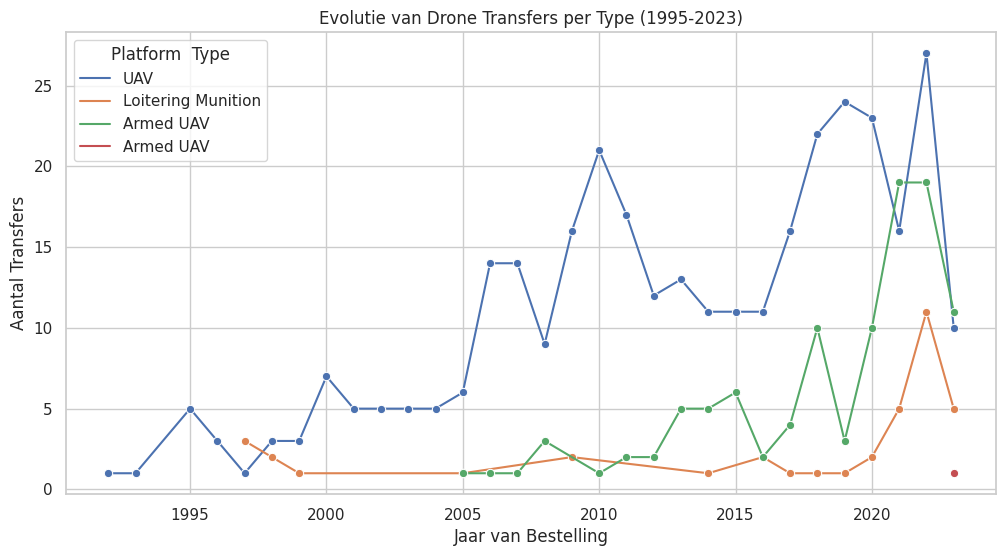

In [40]:
df_trend = df_clean.filter(col("Year of Order").isNotNull()) \
    .groupBy("Year of Order", "Platform  Type") \
    .count() \
    .orderBy("Year of Order")

# Zet om naar Pandas voor visualisatie
pdf_trend = df_trend.toPandas()

# Visualisatie
plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf_trend, x="Year of Order", y="count", hue="Platform  Type", marker="o")

plt.title("Evolutie van Drone Transfers per Type (1995-2023)")
plt.ylabel("Aantal Transfers")
plt.xlabel("Jaar van Bestelling")
plt.show()

## Conclusie Drone Types

We zien dat er een sterke stijging is in de orders en leveringen van Loitering Munition (Kamikaze Drones) vanaf 2020. Dit suggereert een groeiende interesse en vraag naar deze specifieke type drones in de afgelopen jaren. De piek in 2022 kan mogelijk worden toegeschreven aan geopolitieke spanningen (oorlog oekraine) of conflicten die de vraag naar dergelijke wapensystemen hebben aangewakkerd. We zien wel dat dit zogezegd zou afnemen maar dit is omdat de data stopt in september 2023.

### Evolutie drone transfers per land

We zullen proberen waarnemen of er buiten VS en China een opkomst is van nieuwe leveranciers van drones.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

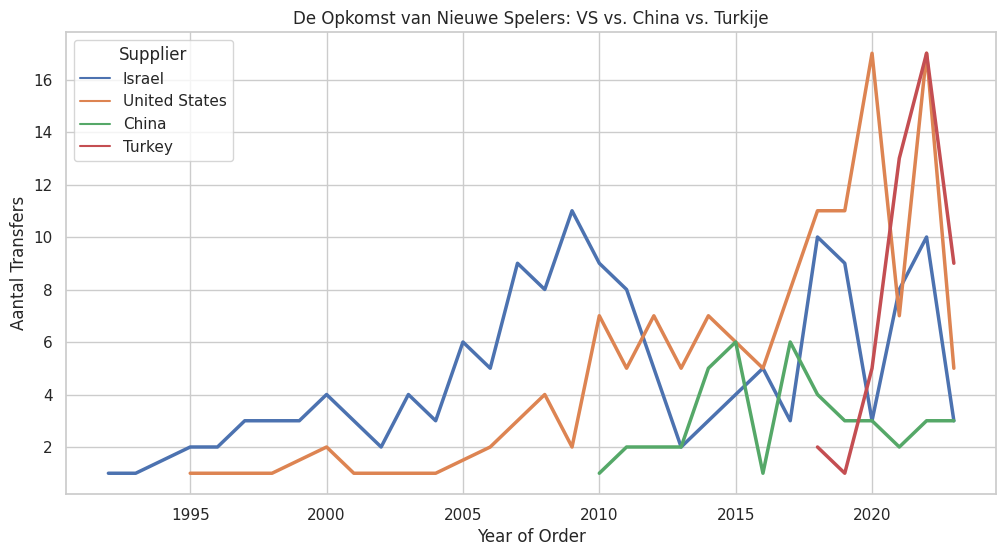

In [41]:
# --- STAP 1: Filteren op Top 3 Suppliers ---
top_suppliers = ["United States", "China", "Turkey", "Israel"]

# Filter de dataset in Spark
df_suppliers = df_clean.filter(col("Supplier").isin(top_suppliers)) \
    .filter(col("Year of Order").isNotNull()) \
    .groupBy("Year of Order", "Supplier") \
    .count() \
    .orderBy("Year of Order")

# Naar Pandas
pdf_suppliers = df_suppliers.toPandas()

# --- STAP 2: Visualisatie ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf_suppliers, x="Year of Order", y="count", hue="Supplier", linewidth=2.5)

plt.title("De Opkomst van Nieuwe Spelers: VS vs. China vs. Turkije")
plt.ylabel("Aantal Transfers")
plt.show()

Een bar chart is hier handig om echt naar het verschil in volume te kijken

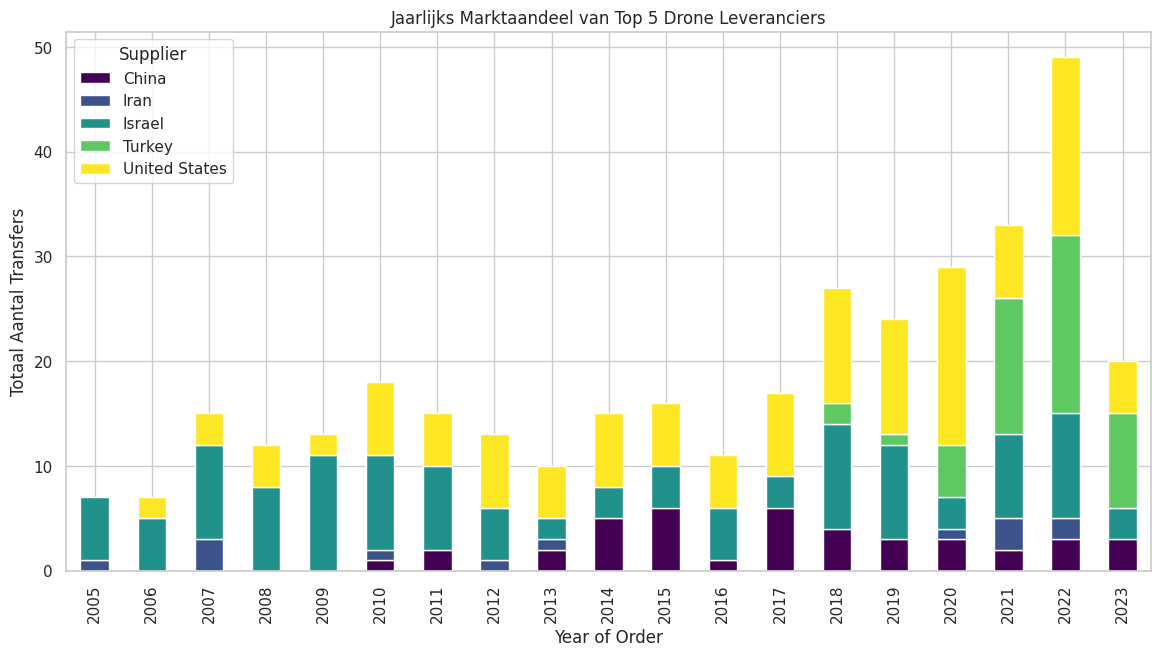

In [42]:
# We nemen de top 5 suppliers
top5_list = [row['Supplier'] for row in df_clean.groupBy("Supplier").count().orderBy(col("count").desc()).limit(5).collect()]

df_market = df_clean.filter(col("Supplier").isin(top5_list)) \
    .filter(col("Year of Order") >= 2005) \
    .groupBy("Year of Order", "Supplier") \
    .count() \
    .orderBy("Year of Order")

# Pivot table in Pandas maken voor stacked bar
pdf_market = df_market.toPandas()
pdf_pivot = pdf_market.pivot(index='Year of Order', columns='Supplier', values='count').fillna(0)

# --- STAP 2: Visualisatie ---
pdf_pivot.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')

plt.title("Jaarlijks Marktaandeel van Top 5 Drone Leveranciers")
plt.ylabel("Totaal Aantal Transfers")
plt.show()

## Conclusie markt analyse

We zien dat de VS en Israel de belangrijkste spelers waren maar recent is Turkije zeer dominant geworden in de drone-markt. Wat opvalt is dat China zogezegd stabiel blijft, maar dit komt omdat 1) China deze info niet standaard vrijgeeft en 2) De bekende DJI Drones behoren tot civiele drones die niet in de scope van deze dataset zitten. Deze landen hebben hun productiecapaciteit en technologische expertise vergroot, wat hen in staat stelt om een grotere rol te spelen in de wereldwijde drone-markt. We weten dat Turkije en Iran actief zijn in conflicten in het Midden-Oosten, wat hun behoefte aan geavanceerde drone-technologie kan verklaren.

We kunnen hier letterlijk zien hoe het gekleurde blok van Turkije (Groen) ineens omhoog schiet rond 2021-2022. Dit bevestigt onze hypothese dat Turkije een opkomende speler is in de drone-markt. Iran (Paars) laat ook een lichte stijging zien, wat aangeeft dat zij ook hun aanwezigheid in deze markt uitbreiden. We stellen ook vast dat van 2000 tot 2004 er eigenlijk maar 2 spelers in de drone markt waren: Israel en VS. Dit toont aan hoe geconcentreerd de markt vroeger was, in tegenstelling tot de meer diverse markt van vandaag.

## Maar wie levert nu eigenlijk aan wie ?

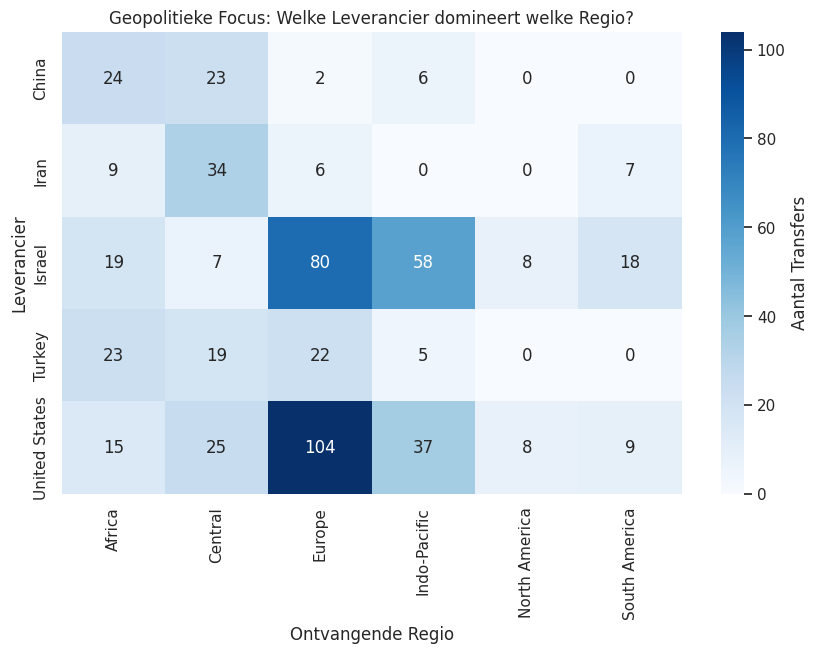

In [43]:
# --- STAP 1: Cross-tabulatie in Spark ---
# We groeperen op Supplier EN Region
df_geo = df_clean.filter(col("Supplier").isin(top5_list)) \
    .groupBy("Supplier", "Region ") \
    .count()

# Naar Pandas en Pivotten (Matrix vorm maken)
pdf_geo = df_geo.toPandas()
matrix_geo = pdf_geo.pivot(index="Supplier", columns="Region ", values="count").fillna(0)

# --- STAP 2: Visualisatie ---
plt.figure(figsize=(10, 6))
sns.heatmap(matrix_geo, annot=True, fmt='g', cmap="Blues", cbar_kws={'label': 'Aantal Transfers'})

plt.title("Geopolitieke Focus: Welke Leverancier domineert welke Regio?")
plt.xlabel("Ontvangende Regio")
plt.ylabel("Leverancier")
plt.show()


## Conclusie Leveringen

We kunnen hier duidelijk zien dat :
- VS veel levert aan "Europa" (NAVO landen) en aan Indo Pacific (waarschijlijk landen zoals Thailand). 
- China levert vooral aan Afrika en Azië. 
- Iran levert vooral aan Midden-Oosten. (alhoewel we bij Iran wel veel "Unknown" zien staan als seeker, dus dit kan vertekenen)
  *Zoals het code book al zegt: "Nonstate actors and authoritarian regimes have significant motivation to keep details... secret"*
- Turkije levert aan Europa en Midden Oosten.

# 2. Dronewars dataset

Gebaseerd op het Drone Wars / Bureau of Investigative Journalism materiaal met individuele VS‑droneaanvallen in Pakistan, Afghanistan, Jemen en Somalië.

Voor elke strike vind je o.a. datum, land/regio, aantal gedode en gewonde personen, burgers vs. strijders, en soms locatiebeschrijvingen, zodat je slachtofferpatronen en geografische spreiding kan analyseren.

## Deel 1: Cleanen van de data

In [44]:

from pyspark.sql.functions import coalesce, expr, trim, regexp_replace, col, year, when, sum

excel_file = "/kaggle/input/drone-strikes/DroneWarsData (3).xlsx" 
csv_file = "dronewars_data_all.csv"
sheet_name = "All"

if not os.path.exists(csv_file):
    print(f"Converteren van {excel_file} naar CSV...")
    try:
        pdf_raw = pd.read_excel(excel_file, sheet_name=sheet_name)
        pdf_raw.to_csv(csv_file, index=False)
        print("Succesvol geconverteerd.")
    except Exception as e:
        print(f"FOUT bij converteren: {e}")
        print("Check of het bestand in de map staat en de naam klopt.")
else:
    print(f"CSV bestand {csv_file} bestaat al. We slaan conversie over.")


df_strikes = spark.read.csv("/kaggle/working/dronewars_data_all.csv", header=True, inferSchema=True)

# Alle kolommen voor de makkelijkheid even veranderen van naam
rename_map = {
    "Minimum total people killed": "min_killed",
    "Maximum total people killed": "max_killed",
    "Minimum civilians reported killed": "min_civilians",
    "Maximum civilians reported killed": "max_civilians",
    "Minimum children reported killed": "min_children",
    "Maximum children reported killed": "max_children",
    "Minimum reported injured": "min_injured",
    "Ratio of Civilians to Total Killed": "ratio_civ_to_total",
    "Other (Non-civilian/children Killed)": "other_killed",
}

# Datum Parsing
df_clean = (
    df_strikes
    .withColumn("parsed_ts", expr("try_to_timestamp(`Date (MM-DD-YYYY)`, 'dd-MM-yyyy')"))
    .filter(col("parsed_ts").isNotNull())  # Verwijder rijen zonder geldige datum
    .withColumn("parsed_date", col("parsed_ts").cast("date"))
    .withColumn("year", year(col("parsed_date")))
)

print(f"Datum parsing voltooid. Rijen met geldige datum: {df_clean.count()}")

# Whitespace Trimming van String Kolommen
string_cols = ["Country", "President"]
for c in string_cols:
    if c in df_clean.columns:
        df_clean = df_clean.withColumn(c, trim(col(c)))

# Coördinaten Fixen
if "Latitude" in df_clean.columns:
    df_clean = df_clean.withColumn("Latitude", regexp_replace(col("Latitude"), "^,", "")) \
                       .withColumn("Latitude", regexp_replace(col("Latitude"), ",", "."))
if "Longitude" in df_clean.columns:
    df_clean = df_clean.withColumn("Longitude", regexp_replace(col("Longitude"), "^,", "")) \
                       .withColumn("Longitude", regexp_replace(col("Longitude"), ",", "."))

# Alle Kolomnamen Hernoemen
for old, new in rename_map.items():
    if old in df_clean.columns:
        df_clean = df_clean.withColumnRenamed(old, new)

# Type Casting naar Integer
int_cols = [
    "min_killed", "max_killed",
    "min_civilians", "max_civilians",
    "min_children", "max_children",
    "min_injured", "other_killed"
]
for c in int_cols:
    if c in df_clean.columns:
        df_clean = df_clean.withColumn(c, col(c).cast("integer"))

# Ratio casting
if "ratio_civ_to_total" in df_clean.columns:
    df_clean = df_clean.withColumn("ratio_civ_to_total", expr("try_cast(ratio_civ_to_total as double)"))

if "Latitude" in df_clean.columns:
    df_clean = df_clean.withColumn("Latitude", expr("try_cast(Latitude as double)"))
if "Longitude" in df_clean.columns:
    df_clean = df_clean.withColumn("Longitude", expr("try_cast(Longitude as double)"))

# Stap F: Nulls Vullen (alleen op integer kolommen)
for c in int_cols:
    if c in df_clean.columns:
        df_clean = df_clean.withColumn(
            c, 
            when(col(c).cast("integer") >= 0, col(c).cast("integer"))
            .otherwise(None)  # Negatieve waarden worden null
        )

print("Data Cleaning Voltooid.")
print(f"Aantal geldige rijen over: {df_clean.count()}")
df_clean.printSchema()



CSV bestand dronewars_data_all.csv bestaat al. We slaan conversie over.
Datum parsing voltooid. Rijen met geldige datum: 682
Data Cleaning Voltooid.
Aantal geldige rijen over: 682
root
 |-- Strike ID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Date (MM-DD-YYYY): string (nullable = true)
 |-- President: string (nullable = true)
 |-- Most Specific Location: string (nullable = true)
 |-- Most Specific Lat/Long: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- min_killed: integer (nullable = true)
 |-- max_killed: integer (nullable = true)
 |-- min_civilians: integer (nullable = true)
 |-- max_civilians: integer (nullable = true)
 |-- min_children: integer (nullable = true)
 |-- max_children: integer (nullable = true)
 |-- min_injured: integer (nullable = true)
 |-- ratio_civ_to_total: double (nullable = true)
 |-- other_killed: integer (nullable = true)
 |-- Unnamed: 17: double (nullable = true)
 |-- p

## Visualisaties

### Aantal drone strikes per president

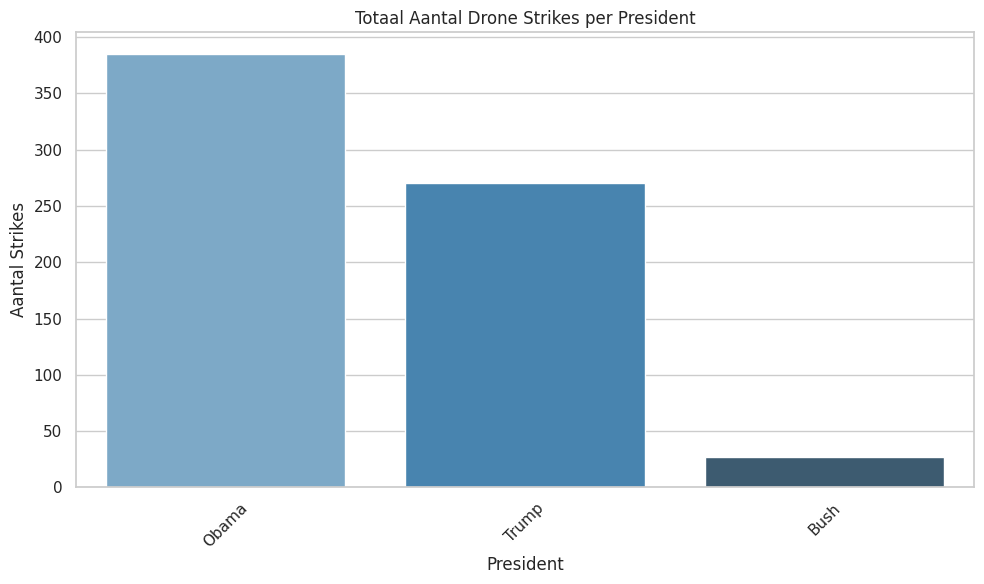

In [45]:
df_pres_count = (
df_clean
.groupBy("President")
.count()
.orderBy("count", ascending=False)
)

pdf_pres_count = df_pres_count.toPandas()
# Plotten (Barplot)
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf_pres_count, x="President", y="count", palette="Blues_d")
plt.title("Totaal Aantal Drone Strikes per President")
plt.xlabel("President")
plt.ylabel("Aantal Strikes")
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

### Dodelijkheid per president

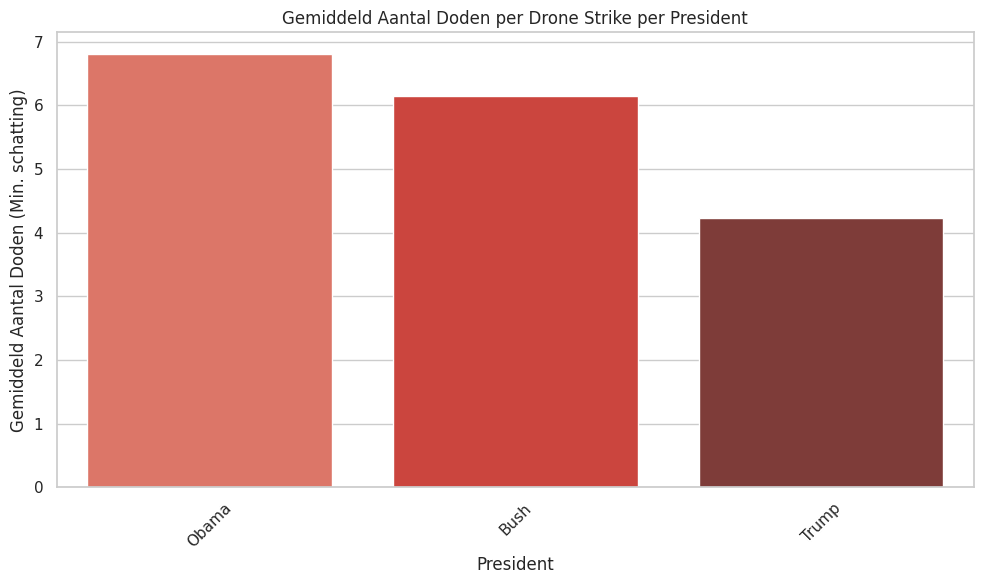

In [46]:
from pyspark.sql.functions import avg
# Stap 1: Aggregeren (Gemiddelde berekenen)
df_pres_avg = (
df_clean
.groupBy("President")
.agg(avg("min_killed").alias("avg_deaths"))
.orderBy("avg_deaths", ascending=False)
)
# Stap 2: Naar Pandas
pdf_pres_avg = df_pres_avg.toPandas()
# Stap 3: Plotten
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf_pres_avg, x="President", y="avg_deaths", palette="Reds_d")
plt.title("Gemiddeld Aantal Doden per Drone Strike per President")
plt.xlabel("President")
plt.ylabel("Gemiddeld Aantal Doden (Min. schatting)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Aantal drone strikes per land

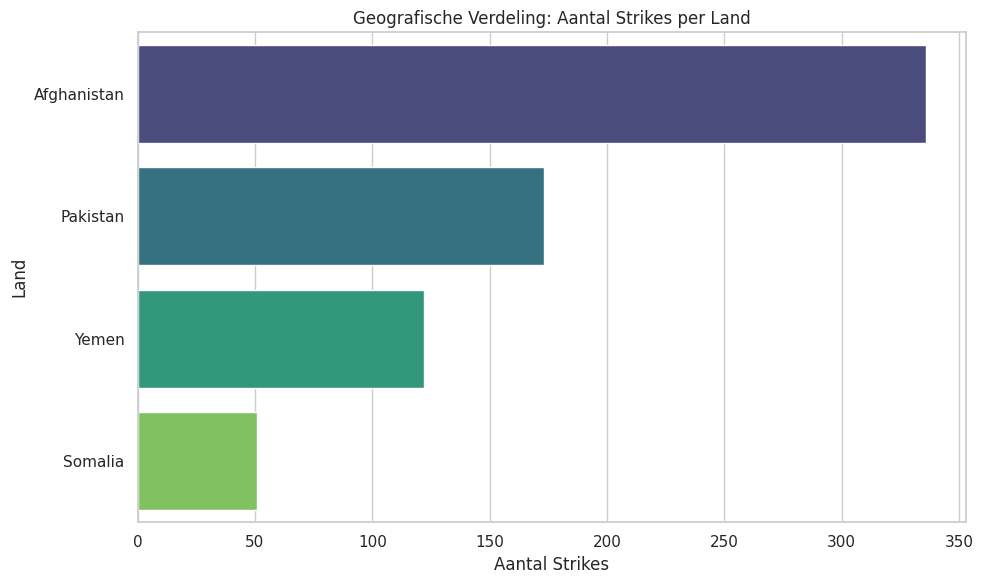

In [47]:
# Stap 1: Aggregeren
df_country_count = (
df_clean
.groupBy("Country")
.count()
.orderBy("count", ascending=False)
)

pdf_country_count = df_country_count.toPandas()

# Stap 3: Plotten (Horizontale Barplot voor betere leesbaarheid landnamen)
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf_country_count, y="Country", x="count", palette="viridis")
plt.title("Geografische Verdeling: Aantal Strikes per Land")
plt.xlabel("Aantal Strikes")
plt.ylabel("Land")
plt.tight_layout()
plt.show()

### Heatmap Jaar vs Land Intensiteit

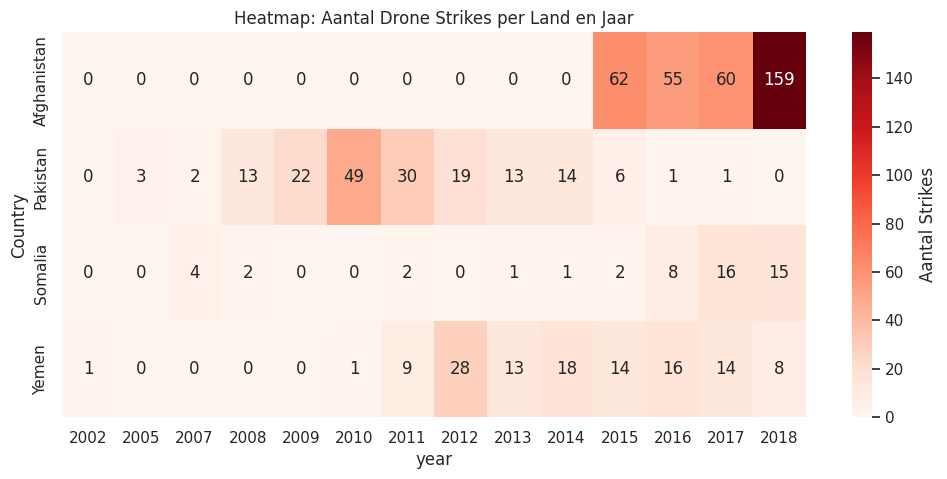

In [48]:
df_heatmap = df_clean.groupBy("Country", "year") \
.count() \
.orderBy("year")
# Pivot in Pandas (Rijen=Land, Kolommen=Jaar, Waarde=Aantal Strikes)
pdf_heatmap = df_heatmap.toPandas()
matrix = pdf_heatmap.pivot(index="Country", columns="year", values="count").fillna(0)
# Plotten
plt.figure(figsize=(12, 5))
sns.heatmap(matrix, annot=True, fmt='g', cmap="Reds", cbar_kws={'label':'Aantal Strikes'})
plt.title("Heatmap: Aantal Drone Strikes per Land en Jaar")
plt.show()

### Conclusie

Het is duidelijk dat de US een war on terror aan het voeren was. 2008-2013 reflecteert dit bij de jacht op Osama Bin Laden. In de word count analyse hieronder zullen we ook zien dat "North Waziristan" de meest voorkomende specifieke locatie is voor drone strikes.

## Data analyses

### Word Count om de meest gebombardeerde locaties te vinden

In [49]:
df_clean.select("Most Specific Location").show(20,truncate=False)

+----------------------------------------------------------------------+
|Most Specific Location                                                |
+----------------------------------------------------------------------+
|Kari Kot, South Waziristan, Pakistan                                  |
|Ghundikala, North Waziristan, Pakistan                                |
|Mandi Khel, North Waziristan, Pakistan                                |
|Mandi Khel, North Waziristan, Pakistan                                |
|Datta Khel, North Waziristan, Pakistan                                |
|Boya, North Waziristan, Pakistan                                      |
|Shabwa, Yemen                                                         |
|Spera, Khost, Afghanistan                                             |
|Madin Village, South Waziristan, Pakistan                             |
|Lajhmarai area, Tehsil Birmal, South Waziristan, Pakistan             |
|Shaltan Darra, Shegal, Kunar, Afghanistan         

In [50]:
# Selecteer de kolom en zet om naar RDD - let hierbij op de structuur ! bv. Alwara Mandi, Datta Khel or Shawal, North Waziristan, Pakistan
rdd_locations = df_clean.select("Most Specific Location") \
.filter(col("Most Specific Location").isNotNull()) \
.rdd.flatMap(lambda row: [loc.strip() for loc in row[0].split(',')])
# Stap 2: Map (woord -> 1) en Reduce (tel op)
# We filteren ook korte woordjes weg (bv. "in", "of", "near")
stop_words = [
"in", "of", "the", "near", "district", "province", "village", "area","unknown",
"north", "south", "east", "west", "central", "northern", "southern","eastern", "western",
"region", "county", "state", "city", "town", "and", "or", "at", "on"
]
word_counts = rdd_locations \
.map(lambda word: word.lower().strip(",.")) \
.filter(lambda word: len(word) > 3 and word not in stop_words) \
.map(lambda word: (word, 1)) \
.reduceByKey(lambda a, b: a + b) \
.sortBy(lambda x: x[1], ascending=False)
# Stap 3: Resultaat tonen
print("Top 10 Meest Genoemde Locaties/Termen:")
for word, count in word_counts.take(10):
    print(f"{word}: {count}")

Top 10 Meest Genoemde Locaties/Termen:
afghanistan: 336
pakistan: 173
north waziristan: 129
yemen: 122
nangarhar: 94
helmand: 43
somalia: 42
south waziristan: 38
achin: 34
kunar: 32


### Conclusie

Ik vraag me af waarom north waziristan zo vaak terugkomt, na een simpele google search vind ik terug dat dit effectief het gebied was waar Osama Bin Laden zich lange tijd schuilhield. Het grenst ook aan Afghanistan.

"It is the northern part of Waziristan, a mountainous region of northwest Pakistan, bordering Afghanistan". 

In [51]:
df_clean.createOrReplaceTempView("strikes")
# Stap 2: SQL Query
# We sommeren de totalen en berekenen dan het percentage
sql_query = """
SELECT
Country,
SUM(min_killed) as total_deaths,
SUM(min_civilians) as civilian_deaths,
ROUND((SUM(min_civilians) / SUM(min_killed)) * 100, 2) as civilian_ratio_pct
FROM strikes
GROUP BY Country
ORDER BY total_deaths DESC
"""
df_ratios = spark.sql(sql_query)
df_ratios.show()

+-----------+------------+---------------+------------------+
|    Country|total_deaths|civilian_deaths|civilian_ratio_pct|
+-----------+------------+---------------+------------------+
|Afghanistan|        2020|            153|              7.57|
|   Pakistan|         981|            115|             11.72|
|      Yemen|         499|             50|             10.02|
|    Somalia|         428|             14|              3.27|
+-----------+------------+---------------+------------------+



## Folium

#### 2 lagen: Strike density en individuele strikes

In [52]:
df_clean.select("Latitude","Longitude").show(10)
# Oke top, onze coordinaten zien er goed uit

+---------+---------+
| Latitude|Longitude|
+---------+---------+
|32.270651|69.554179|
|32.959854|70.156371|
|33.001031|70.364339|
|33.001031|70.364339|
|33.150049|70.433361|
|32.943336|69.899944|
| 14.75463|46.516261|
| 33.19392|69.515022|
|32.320237| 69.85974|
|32.378567|69.430782|
+---------+---------+
only showing top 10 rows



In [53]:
import folium
from folium.plugins import HeatMap

# --- Geo Visualisatie: Markers & Heatmap ---
df_geo = df_clean.filter((col("Latitude") != 0) & (col("Latitude").isNotNull())) \
    .select("Latitude", "Longitude", "min_killed","min_civilians", "Date (MM-DD-YYYY)", "Country")
pdf_geo = df_geo.toPandas()

# Kaart opzetten
m = folium.Map(location=[32, 65], zoom_start=4, tiles="CartoDB dark_matter")

# Eerste laag: Heatmap
heat_data = [[row['Latitude'], row['Longitude'], row['min_killed']] for index, row in pdf_geo.iterrows()]
HeatMap(heat_data, radius=15, blur=10, name="Strike Density").add_to(m)

# Tweede laag: Individuele Markers
marker_group = folium.FeatureGroup(name="Individual Strikes")
for _, row in pdf_geo.iterrows():
    color = "red" if row['min_civilians'] > 0 else "blue"
    
    
    popup_html = f"""
    <b>Datum:</b> {row['Date (MM-DD-YYYY)']}<br>
    <b>Land:</b> {row['Country']}<br>
    <b>Totaal Doden:</b> {row['min_killed']}<br>
    <b>Burgers:</b> {row['min_civilians']}
    """
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=200)
    ).add_to(marker_group)

marker_group.add_to(m)
folium.LayerControl().add_to(m)

# Weergeven
m


# 3. Ukraine Missiles 

Kaggle‑dataset met dagelijkse Russische missile‑ en drone‑aanvallen op Oekraïne, inclusief tijdsvensters, wapentype (model), lanceerlocaties, targets, aantallen gelanceerd/onderschept en getroffen regio’s.

Hiermee breng je de schaal en intensiteit van massale raket‑ en Shahed‑golven in kaart en kun je interceptieratio’s, regionale spreiding (oblasten) en evolutie in tijd analyseren

## Verkennen

In [55]:
csv_file = "/kaggle/input/ukraine-daily-attacks/missile_attacks_daily.csv"

df_missiles = spark.read.csv(csv_file, header=True, inferSchema=True)

print("Schema van de Ukraine Missile Attacks dataset:")
df_missiles.printSchema()

Schema van de Ukraine Missile Attacks dataset:
root
 |-- time_start: timestamp (nullable = true)
 |-- time_end: timestamp (nullable = true)
 |-- model: string (nullable = true)
 |-- launch_place: string (nullable = true)
 |-- target: string (nullable = true)
 |-- target_main: string (nullable = true)
 |-- launched: double (nullable = true)
 |-- destroyed: double (nullable = true)
 |-- not_reach_goal: double (nullable = true)
 |-- still_attacking: double (nullable = true)
 |-- border_crossing: string (nullable = true)
 |-- is_shahed: double (nullable = true)
 |-- num_hit_location: double (nullable = true)
 |-- num_fall_fragment_location: double (nullable = true)
 |-- carrier: string (nullable = true)
 |-- turbojet: double (nullable = true)
 |-- turbojet_destroyed: double (nullable = true)
 |-- affected region: string (nullable = true)
 |-- destroyed_details: string (nullable = true)
 |-- launched_details: string (nullable = true)
 |-- launch_place_details: string (nullable = true)
 |-- 

In [56]:

cols_to_show = ["time_start", "time_end", "model", "launch_place", "launched", "destroyed"]
df_missiles.select(cols_to_show).show(5, truncate=20)


+-------------------+-------------------+----------------+--------------------+--------+---------+
|         time_start|           time_end|           model|        launch_place|launched|destroyed|
+-------------------+-------------------+----------------+--------------------+--------+---------+
|2025-12-06 18:00:00|2025-12-07 09:00:00|    X-47 Kinzhal|       Tambov oblast|     3.0|      2.0|
|2025-12-06 18:00:00|2025-12-07 09:00:00|  Shahed-136/131|Primorsko-Akhtars...|   241.0|    175.0|
|2025-12-06 18:00:00|2025-12-07 09:00:00|Iskander-M/KN-23|        Kursk oblast|     2.0|      2.0|
|2025-12-05 18:00:00|2025-12-06 10:00:00|  Shahed-136/131|Primorsko-Akhtars...|   653.0|    585.0|
|2025-12-05 18:00:00|2025-12-06 10:00:00|Iskander-M/KN-23|Crimea and Bryans...|    14.0|      1.0|
+-------------------+-------------------+----------------+--------------------+--------+---------+
only showing top 5 rows



In [57]:
# Even wat mooier met pandas

df_missiles_pd = df_missiles.limit(5).toPandas()
df_missiles_pd

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,time_start,time_end,model,launch_place,target,target_main,launched,destroyed,not_reach_goal,still_attacking,...,num_hit_location,num_fall_fragment_location,carrier,turbojet,turbojet_destroyed,affected region,destroyed_details,launched_details,launch_place_details,source
0,2025-12-06 18:00:00,2025-12-07 09:00:00,X-47 Kinzhal,Tambov oblast,Ukraine,None,3.0,2.0,NaN,NaN,...,NaN,NaN,MiG-31K,NaN,NaN,None,None,None,None,kpszsu/posts/pfbid0d2Rx2p1iSxS4i874x54NCZzg9fc...
1,2025-12-06 18:00:00,2025-12-07 09:00:00,Shahed-136/131,"Primorsko-Akhtarsk and Chauda, Crimea and Kurs...",Ukraine,None,241.0,175.0,0.0,NaN,...,14.0,0.0,None,NaN,NaN,None,"{'south': 8, 'north': NaN, 'east': NaN}",None,None,kpszsu/posts/pfbid0d2Rx2p1iSxS4i874x54NCZzg9fc...
2,2025-12-06 18:00:00,2025-12-07 09:00:00,Iskander-M/KN-23,Kursk oblast,Ukraine,None,2.0,2.0,NaN,NaN,...,NaN,NaN,None,NaN,NaN,None,None,None,None,kpszsu/posts/pfbid0d2Rx2p1iSxS4i874x54NCZzg9fc...
3,2025-12-05 18:00:00,2025-12-06 10:00:00,Shahed-136/131,"Primorsko-Akhtarsk and Chauda, Crimea and Kurs...",Ukraine,None,653.0,585.0,0.0,NaN,...,29.0,3.0,None,NaN,NaN,"['Lviv oblast', 'Ivano-Frankivsk oblast', 'Lut...","{'west': 39, 'south': 28, 'north': NaN, 'east'...",None,None,kpszsu/posts/pfbid08V2L3Y6pPBmVG3bXDkQWysJ4fhR...
4,2025-12-05 18:00:00,2025-12-06 10:00:00,Iskander-M/KN-23,Crimea and Bryansk oblast and Rostov oblast an...,Ukraine,None,14.0,1.0,NaN,NaN,...,NaN,NaN,None,NaN,NaN,None,None,None,None,kpszsu/posts/pfbid08V2L3Y6pPBmVG3bXDkQWysJ4fhR...


In [58]:
# Nu eens met SQL style view 
df_missiles.createOrReplaceTempView("missiles")
spark.sql("SELECT * FROM missiles LIMIT 5").toPandas()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,time_start,time_end,model,launch_place,target,target_main,launched,destroyed,not_reach_goal,still_attacking,...,num_hit_location,num_fall_fragment_location,carrier,turbojet,turbojet_destroyed,affected region,destroyed_details,launched_details,launch_place_details,source
0,2025-12-06 18:00:00,2025-12-07 09:00:00,X-47 Kinzhal,Tambov oblast,Ukraine,None,3.0,2.0,NaN,NaN,...,NaN,NaN,MiG-31K,NaN,NaN,None,None,None,None,kpszsu/posts/pfbid0d2Rx2p1iSxS4i874x54NCZzg9fc...
1,2025-12-06 18:00:00,2025-12-07 09:00:00,Shahed-136/131,"Primorsko-Akhtarsk and Chauda, Crimea and Kurs...",Ukraine,None,241.0,175.0,0.0,NaN,...,14.0,0.0,None,NaN,NaN,None,"{'south': 8, 'north': NaN, 'east': NaN}",None,None,kpszsu/posts/pfbid0d2Rx2p1iSxS4i874x54NCZzg9fc...
2,2025-12-06 18:00:00,2025-12-07 09:00:00,Iskander-M/KN-23,Kursk oblast,Ukraine,None,2.0,2.0,NaN,NaN,...,NaN,NaN,None,NaN,NaN,None,None,None,None,kpszsu/posts/pfbid0d2Rx2p1iSxS4i874x54NCZzg9fc...
3,2025-12-05 18:00:00,2025-12-06 10:00:00,Shahed-136/131,"Primorsko-Akhtarsk and Chauda, Crimea and Kurs...",Ukraine,None,653.0,585.0,0.0,NaN,...,29.0,3.0,None,NaN,NaN,"['Lviv oblast', 'Ivano-Frankivsk oblast', 'Lut...","{'west': 39, 'south': 28, 'north': NaN, 'east'...",None,None,kpszsu/posts/pfbid08V2L3Y6pPBmVG3bXDkQWysJ4fhR...
4,2025-12-05 18:00:00,2025-12-06 10:00:00,Iskander-M/KN-23,Crimea and Bryansk oblast and Rostov oblast an...,Ukraine,None,14.0,1.0,NaN,NaN,...,NaN,NaN,None,NaN,NaN,None,None,None,None,kpszsu/posts/pfbid08V2L3Y6pPBmVG3bXDkQWysJ4fhR...


## Data cleaning

In [59]:
from pyspark.sql import functions as F
from pyspark.sql.functions import (
col, year, month, date_format, to_date,
sum as spark_sum, avg, count, round as spark_round
)

# Datumkolommen omzetten alsook jaar/maand toevoegen
df_clean = (df_missiles
    .withColumn("date", to_date(col("time_start")))
    .withColumn("year", year(col("time_start")))
    .withColumn("month", month(col("time_start")))
    .withColumn("year_month", date_format(col("time_start"), "yyyy-MM")))

# Kolommen trimmen en NULLs opvullen voor numerieke kolommen
numeric_cols = ["launched", "destroyed", "not_reach_goal", "is_shahed",
                "turbojet", "turbojet_destroyed"]

for c in numeric_cols:
    if c in df_clean.columns:  # FIXED: Proper indentation (4 spaces)
        df_clean = df_clean.fillna(0.0, subset=[c])  # FIXED: Proper indentation (8 spaces)

# Controleer
print(f"Aantal geldige rijen: {df_clean.count()}")
df_clean.select("date", "year", "year_month", "model", "launched", "destroyed").show(10)


Aantal geldige rijen: 3174
+----------+----+----------+--------------------+--------+---------+
|      date|year|year_month|               model|launched|destroyed|
+----------+----+----------+--------------------+--------+---------+
|2025-12-06|2025|   2025-12|        X-47 Kinzhal|     3.0|      2.0|
|2025-12-06|2025|   2025-12|      Shahed-136/131|   241.0|    175.0|
|2025-12-06|2025|   2025-12|    Iskander-M/KN-23|     2.0|      2.0|
|2025-12-05|2025|   2025-12|      Shahed-136/131|   653.0|    585.0|
|2025-12-05|2025|   2025-12|    Iskander-M/KN-23|    14.0|      1.0|
|2025-12-05|2025|   2025-12|X-101/X-555 and K...|    34.0|     29.0|
|2025-12-06|2025|   2025-12|        X-47 Kinzhal|     3.0|      0.0|
|2025-12-06|2025|   2025-12|              Молнія|     5.0|      5.0|
|2025-12-04|2025|   2025-12|      Shahed-136/131|   137.0|     80.0|
|2025-12-05|2025|   2025-12|              Молнія|     5.0|      5.0|
+----------+----+----------+--------------------+--------+---------+
only sh

## Data  Analyses

#### Totaal gelanceerd vs neergeschoten per dag

In [60]:
daily_agg = (df_clean
    .groupBy("date", "model")  # ADDED: Include 'model' in groupBy
    .agg(
        spark_sum("launched").alias("total_launched"),
        spark_sum("destroyed").alias("total_destroyed")
    )
    .withColumn("success_rate",
        spark_round(col("total_destroyed") / col("total_launched"), 3))
    .orderBy("date"))

daily_agg.show(30)


+----------+--------------------+--------------+---------------+------------+
|      date|               model|total_launched|total_destroyed|success_rate|
+----------+--------------------+--------------+---------------+------------+
|2022-09-28|  Reconnaissance UAV|           3.0|            3.0|         1.0|
|2022-09-28|                X-59|           5.0|            4.0|         0.8|
|2022-09-29|      Shahed-136/131|           7.0|            5.0|       0.714|
|2022-09-30|            Orlan-10|           3.0|            3.0|         1.0|
|2022-10-01|            Orlan-10|           1.0|            1.0|         1.0|
|2022-10-02|      Shahed-136/131|           7.0|            5.0|       0.714|
|2022-10-05|      Shahed-136/131|           7.0|            7.0|         1.0|
|2022-10-05|            Orlan-10|           1.0|            1.0|         1.0|
|2022-10-06|           Mohajer-6|           2.0|            2.0|         1.0|
|2022-10-06|            Orlan-10|           1.0|            1.0|

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

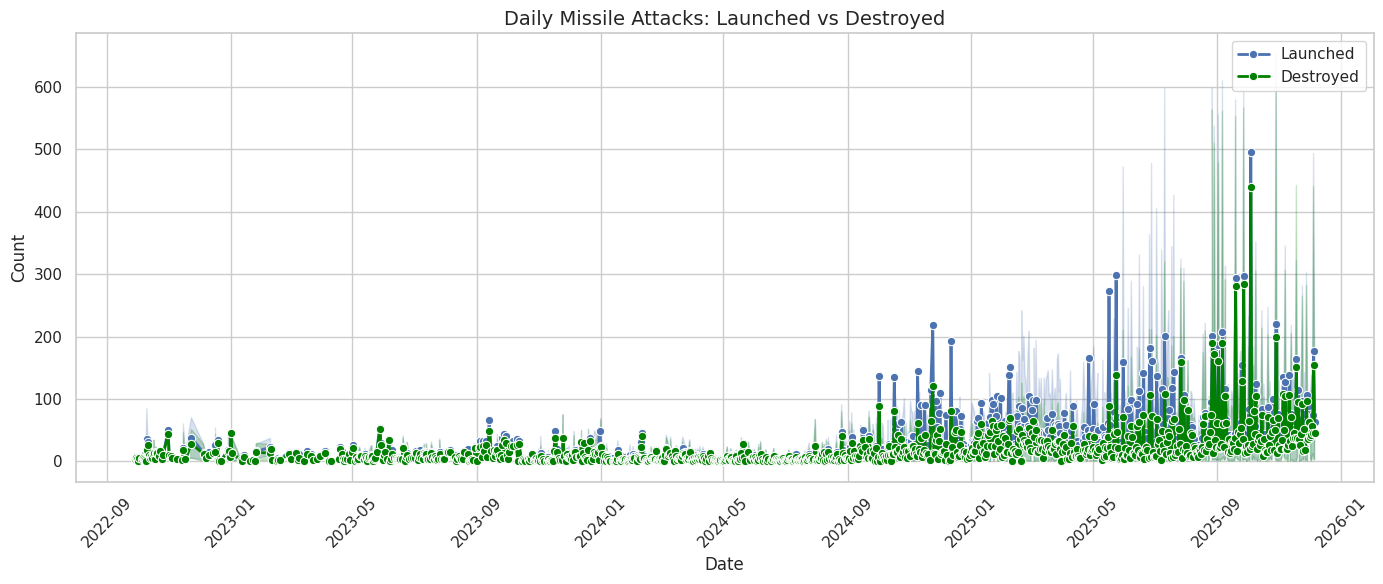

In [61]:
pdf_daily = daily_agg.toPandas().set_index("date")
plt.figure(figsize=(14, 6))
sns.lineplot(data=pdf_daily, x=pdf_daily.index, y="total_launched",
label="Launched", marker='o', linewidth=2)
sns.lineplot(data=pdf_daily, x=pdf_daily.index, y="total_destroyed",
label="Destroyed", marker='o', linewidth=2, color='green')
plt.title("Daily Missile Attacks: Launched vs Destroyed", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Success rate per model

In [62]:
weapon_agg = (df_clean
.groupBy("model")
.agg(
spark_sum("launched").alias("total_launched"),
spark_sum("destroyed").alias("total_destroyed")
)
.withColumn("success_rate",
spark_round(col("total_destroyed") /col("total_launched"), 3)).filter(col("total_launched") > 5) # filter rare wapens eruit
.orderBy(col("total_launched").desc()))
weapon_agg.show(20, truncate=False)

+----------------------+--------------+---------------+------------+
|model                 |total_launched|total_destroyed|success_rate|
+----------------------+--------------+---------------+------------+
|Shahed-136/131        |65488.0       |44384.0        |0.678       |
|X-101/X-555           |1808.0        |1535.0         |0.849       |
|Unknown UAV           |855.0         |841.0          |0.984       |
|X-101/X-555 and Kalibr|643.0         |508.0          |0.79        |
|Kalibr                |464.0         |368.0          |0.793       |
|Iskander-M            |411.0         |69.0           |0.168       |
|Lancet                |355.0         |355.0          |1.0         |
|Iskander-M/KN-23      |352.0         |88.0           |0.25        |
|C-300                 |345.0         |2.0            |0.006       |
|Reconnaissance UAV    |335.0         |334.0          |0.997       |
|ZALA                  |309.0         |308.0          |0.997       |
|X-59/X-69             |274.0     

#### Eens kijken naar de combinatie in de welke lanceringen worden uitgevoerd

In [63]:
shahed_agg = (df_clean
.groupBy("is_shahed")
.agg(
spark_sum("launched").alias("total_launched"),
spark_sum("destroyed").alias("total_destroyed"),
count("*").alias("num_attacks")
)
.withColumn("success_rate",
spark_round(col("total_destroyed") /col("total_launched"), 3)))
shahed_agg.show()

+---------+--------------+---------------+-----------+------------+
|is_shahed|total_launched|total_destroyed|num_attacks|success_rate|
+---------+--------------+---------------+-----------+------------+
|     70.0|         888.0|          683.0|          8|       0.769|
|      0.0|       59410.0|        38677.0|       3085|       0.651|
|    255.0|         400.0|          198.0|          1|       0.495|
|    350.0|         596.0|          558.0|          1|       0.936|
|     29.0|          35.0|           11.0|          1|       0.314|
|     75.0|         122.0|          104.0|          1|       0.852|
|     35.0|          62.0|           39.0|          1|       0.629|
|     80.0|        1931.0|         1426.0|         14|       0.738|
|    250.0|        1780.0|         1596.0|          4|       0.897|
|    300.0|        2017.0|         1838.0|          4|       0.911|
|     25.0|          96.0|           78.0|          2|       0.813|
|     85.0|         138.0|          114.0|      

## Conclusie

De baseline voor “0 Shaheds” (kolomwaarde 0.0) heeft een lagere interceptieratio (0.651), wat erop lijkt dat klassieke raketten/missiles gemiddeld moeilijker volledig te stoppen zijn dan Shahed‑drones. Dit is redelijk logisch, maar als we nu eens dieper gaan kijken naar de combinatie van lanceringen valt ons wel iets op:

- Groepen met zeer grote Shahed‑aantallen per aanval (200, 250, 300, 350, 400) hebben hoge succesratio’s (rond 0.75–0.93), wat erop wijst dat massale Shahed‑swarms vaak grotendeels worden neergehaald. Dit is logisch maar mislijdend, het doel van deze shahed drones is namelijk de luchtafweer te verzadigen. 

- Kleine Shahed‑series (bijv. 25–35 drones) tonen soms lage ratios (0.31–0.63), maar die rijen zijn gebaseerd op 1 à 2 aanvallen en zijn dus statistisch zwak

We zien dat de success rate bij de shahed drones lager ligt. De success rate ligt hier lager omdat deze in gigantische aantallen worden afgevuurd. Als we kijken naar de timing van de lancering, zien we duidelijk een trend waarbij eerst de shahed drones de lucht in worden gestuurd om de lucht afweer van Oekraine te verzadigen, en vervolgens hyperballistische raketten die belangrijke strategische doelwitten hebben ingesteld gekregen. Zoals we zien is de success rate van ballistische raketten (Iskander en Kinzhal types) redelijk laag, mede net door deze timing van de shahed drones (maar ook omdat hyperballistische raketten gewoonweg moeilijk uit de lucht te halen zijn).

## Visualisaties

### Heatmap: intensiteit per maand x wapentype

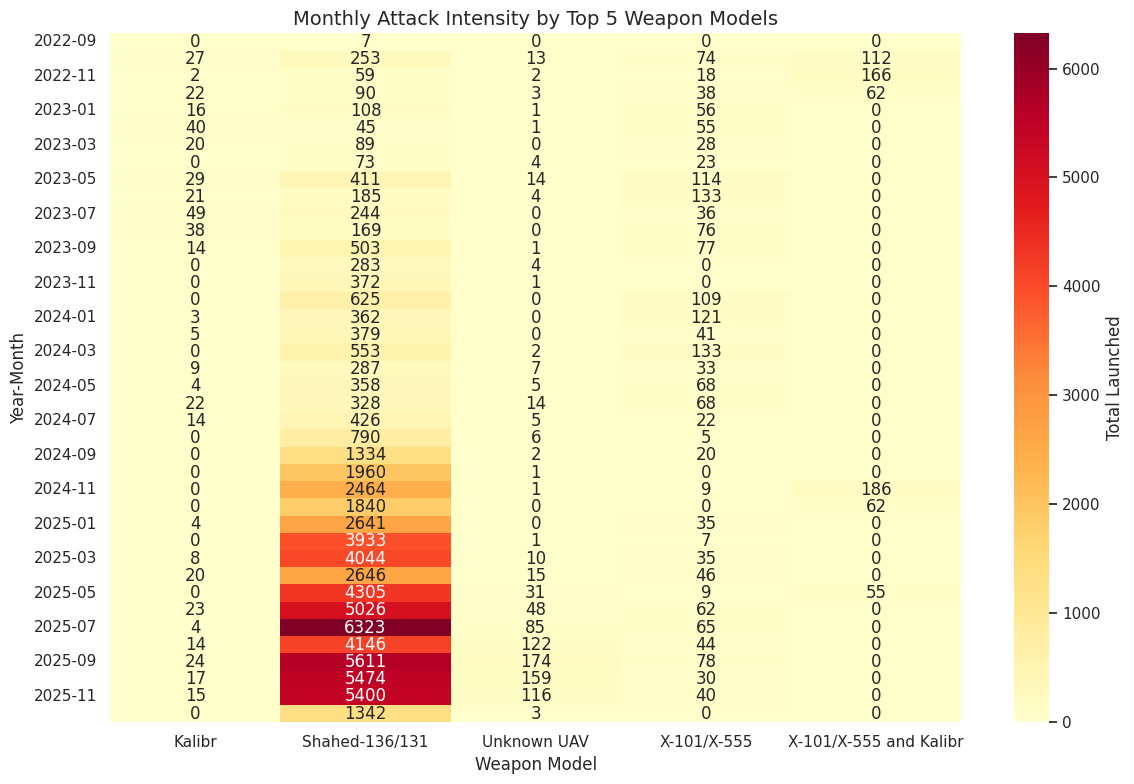

In [64]:
# Filter top 5 modellen voor leesbaarheid
top5_models = [row["model"] for row in weapon_agg.limit(5).collect()]
heatmap_data = (df_clean
.filter(col("model").isin(top5_models))
.groupBy("year_month", "model")
.agg(spark_sum("launched").alias("total"))
.orderBy("year_month")
.toPandas())
# Pivot voor heatmap: rijen = maand, kolommen = model
matrix_heat = heatmap_data.pivot(index="year_month", columns="model",values="total").fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_heat, annot=True, fmt="g", cmap="YlOrRd",
cbar_kws={"label": "Total Launched"})
plt.title("Monthly Attack Intensity by Top 5 Weapon Models", fontsize=14)
plt.xlabel("Weapon Model")
plt.ylabel("Year-Month")
plt.tight_layout()

### Interessante Bevinding: 

We weten dat Rusland begin 2024 is begonnen met produceren (eerste fase van opstart productie) van hun eigen Shahed type drones ipv ze te importeren van Iran. Hiervoor assembleerde ze deze iraanse drone kits in Rusland, maar sinds 2024 maakt Rusland ze volledig zelf (goedkoper). We kunnen dit goed waarnemen in deze heathmap waar begin 2025 heel veel shahed drones werden gelanceerd waar ze voordien de capaciteit niet voor hadden. Deze shahed drones zijn aanzienlijk goedkoper (20-40k) dan de balisstische raketten (bv. Kalibr : $2–$2.4 million per unit). 

Dit is een interessante bevinding (als we aannemen dat alle gecensureerde ontvangers uit deel 1 van deze opdracht Rusland is, waarbij de supplier Iran is) omdat Rusland de grootste afnemer was van deze drones, en dit was Iran hun "paradepaartje" maar nu deze afzetmarkt verdwijnt voor Iran kan dit wel een probleem zijn gezien de gigantische merde aan sancties dat ze al op hun dak hebben. 


### Folium map

### Voorbereiden

In [65]:
import ast

# Parse de list-strings naar echte lijsten en explode
def parse_region_list(region_str):
    """Parse string representation of list to actual list""" 
    if isinstance(region_str, str):
        try:
            return ast.literal_eval(region_str)
        except:
            return [region_str]
    return region_str if isinstance(region_str, list) else [region_str]

# Eerst naar Pandas, parse, explode
temp_pdf = df_clean.select("affected region", "launched", "destroyed").toPandas()
temp_pdf["region"] = temp_pdf["affected region"].apply(parse_region_list)
temp_pdf = temp_pdf.explode("region")

# Nu aggregeren per individuele regio
region_agg = (temp_pdf
    .groupby("region")
    .agg({
        "launched": "sum",
        "destroyed": "sum",
        "region": "count"  # aantal aanvallen
    })
    .rename(columns={"region": "num_attacks",
                     "launched": "total_launched",
                     "destroyed": "total_destroyed"})
    .reset_index()
    .rename(columns={"region": "affected_region"})
)

# Success rate toevoegen
region_agg["success_rate"] = (region_agg["total_destroyed"] / region_agg["total_launched"]).round(3)
region_agg.head(10)

,affected_region,total_launched,total_destroyed,num_attacks,success_rate
0,Cherkasy oblast,4650.0,3098.0,29,0.666
1,Chernihiv oblast,7709.0,5672.0,37,0.736
2,Chernivtsi oblast,772.0,410.0,2,0.531
3,Dnipropetrovsk oblast,16890.0,11414.0,93,0.676
4,Donetsk oblast,13829.0,9182.0,83,0.664
5,Ivano-Frankivsk oblast,4204.0,3384.0,11,0.805
6,Kharkiv oblast,19210.0,11850.0,122,0.617
7,Kherson oblast,80.0,15.0,1,0.188
8,Khmelnytskyi oblast,5730.0,4225.0,17,0.737
9,Kirovohrad oblast,3507.0,2530.0,16,0.721


We gaan geopy gebruiken voor regios om te zetten naar cooordinaten die we dan zullen opslagen in een aparte dataset

In [66]:
!pip install geopy

In [68]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="ukraine_missile_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def geocode_region(name):
    """Geocodeer Oekraïense oblast/regio namen""" 
    try:  
        # Probeer eerst exacte naam
        location = geocode(f"{name}, Ukraine")  
        if location:  
            return pd.Series({"lat": location.latitude, "lon": location.longitude})  
        
        # Fallback: zonder "oblast" suffix
        name_clean = name.replace(" oblast", "").replace(" region", "")  
        location = geocode(f"{name_clean}, Ukraine")  
        if location:
            return pd.Series({"lat": location.latitude, "lon": location.longitude})  
    except Exception as e:
        print(f"Fout bij geocoding {name}: {e}")  
    
    return pd.Series({"lat": None, "lon": None}) 

# Geocodeer unieke regio's (run 1x en sla op in CSV)
geo_df = region_agg.copy()
geo_df[["lat", "lon"]] = geo_df["affected_region"].apply(geocode_region)
geo_df.to_csv("ukraine_regions_geocoded.csv", index=False)

# 
# Later: geo_df = pd.read_csv("ukraine_regions_geocoded.csv")
geo_df.head()


,affected_region,total_launched,total_destroyed,num_attacks,success_rate,lat,lon
0,Cherkasy oblast,4650.0,3098.0,29,0.666,49.146017,31.227174
1,Chernihiv oblast,7709.0,5672.0,37,0.736,51.272593,31.741723
2,Chernivtsi oblast,772.0,410.0,2,0.531,48.381079,26.108167
3,Dnipropetrovsk oblast,16890.0,11414.0,93,0.676,48.662589,34.950172
4,Donetsk oblast,13829.0,9182.0,83,0.664,47.921291,37.780983


### Circlemarkers map die aangeeft hoe goed een gebied gecovered is door luchtafweer

Hoge success rate = goed beveiligd = groen

Lagere success rate = minder goed beveiligd = oranje of zelfs rood

In [74]:
# Kaart centreren op Oekraïne
m = folium.Map(location=[49.0, 31.5], zoom_start=6, tiles="CartoDB positron")

# Kleurcodering op basis van success-rate
for _, row in geo_df.dropna(subset=["lat", "lon"]).iterrows():
    rate = row["success_rate"]  
    
    # Kleur: groen = hoog, oranje = medium, rood = laag
    if rate >= 0.7:  
        color = "green" 
    elif rate >= 0.4:  
        color = "orange"  
    else:  
        color = "red"  
    
    # Radius proportioneel aan aantal aanvallen, hier hebben we wat mee moeten spelen om dit goed te krijgen
    radius = row["total_launched"] / 150.00
    
    popup_html = f"""
    <b>{row['affected_region']}</b><br>
    Total launched: {int(row['total_launched'])}<br>
    Total destroyed: {int(row['total_destroyed'])}<br>
    Success rate: {rate:.2%}<br>
    Num attacks: {int(row['num_attacks'])}
    """  
    
    # FIXED: Removed stray "16"
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=250)
    ).add_to(m)  

# Voeg legenda toe (handmatig)
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 200px;
background-color: white; border:2px solid grey; z-index:9999;
font-size:14px; padding: 10px">
<p><b>Success Rate</b></p>
<p><i class="fa fa-circle" style="color:green"></i> >= 70%</p>
<p><i class="fa fa-circle" style="color:orange"></i> 40-70%</p>
<p><i class="fa fa-circle" style="color:red"></i> < 40%</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
m.save("ukraine_missile_attacks_map.html")
m


### HeatMap van aanvalsintensiteit

Doel: Nagaan of de meest beveiligde luchtzones ook effectief vaak het doelwit zijn van aanvallen

In [76]:

# Voor dit voorbeeld maken we een heatmap per regio met "gewicht" = total_launched

heat_data = [
    [row["lat"], row["lon"], row["total_launched"]]
    for _, row in geo_df.dropna(subset=["lat", "lon"]).iterrows()
]

m2 = folium.Map(location=[49.0, 31.5], zoom_start=6, tiles="CartoDB dark_matter")
HeatMap(heat_data, radius=35, blur=20, name="Attack Density").add_to(m2)
folium.LayerControl().add_to(m2)

# Display the map
m2


## Jupyter widgets

### Dropdown filter jaar selecteren

In [77]:
# --- WIDGET 1: Jaar-filter voor tijdreeks (zoals "Land filter" bij Dronewars) ---
pdf_full = daily_agg.toPandas()
pdf_full["date"] = pd.to_datetime(pdf_full["date"])  # Zet om naar datetime
pdf_full["year"] = pdf_full["date"].dt.year

@widgets.interact(year=sorted(pdf_full["year"].unique()))
def plot_year_trend(year):
    """Plot tijdreeks voor geselecteerd jaar"""
    subset = pdf_full[pdf_full["year"] == year]
    
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=subset, x="date", y="total_launched", label="Launched", marker='o')
    sns.lineplot(data=subset, x="date", y="total_destroyed", label="Destroyed", marker='o', color='green')
    plt.title(f"Missile Attacks in {year}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='year', options=(2022, 2023, 2024, 2025), value=2022), Output()), _…

# Eindconclusie

De data visualisatie opdrachten tonen een dynamisch beeld van moderne oorlogsvoering.

- **Marktverschuiving:** De drone-markt is getransformeerd van een duopolie (VS & Israël) naar een divers landschap waarin nieuwe spelers zoals Turkije en Iran een cruciale rol spelen. Dit heeft de toegang tot geavanceerde drone-technologie gedemocratiseerd, maar ook de verspreiding naar conflictgebieden versneld.
    
- **Strategische Inzet:** De verschuiving naar 'Loitering Munition' en het gebruik van massale drone-zwermen (zoals gezien in Oekraïne) toont aan dat drones niet langer alleen voor verkenning of precisie-aanvallen zijn, maar ingezet worden als strategische wapens om luchtafwe te overweldigen.
    
- **Verdedigingsuitdaging:** Hoewel luchtafweersystemen effectief kunnen zijn tegen drones, blijft de verdediging tegen een combinatie van verzadigingsaanvallen (drones) en geavanceerde ballistische raketten een complexe uitdaging. De lagere interceptieratio van raketten zoals de Kinzhal bevestigt dat pure snelheid en geavanceerde technologie nog steeds een voordeel bieden boven huidige verdedigingssystemen.
    

Samenvattend toont deze analyse aan dat de proliferatie van drones de aard van conflicten fundamenteel heeft veranderd, waarbij toegankelijkheid en massaproductie nieuwe uitdagingen vormen voor globale defensie administraties.